In [0]:
# import shutil 
# shutil.rmtree('data/catsvsdogs')

# Transfer Learning

In this notebook, we will go through basics of Transfer Learning using [Cats vs Dogs Redux](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/data) Competition dataset from kaggle.

Here we will use [PyTorch](https://pytorch.org/tutorials/  "PyTorch Tutorial").


Hey yo, but what is Transfer Learning?

Everything is explained in-detail in [blog post](https://dudeperf3ct.github.io/transfer/learning/catsvsdogs/2018/11/20/Power-of-Transfer-Learning/). This is notebook which replicates the result of blog and runs in colab. Enjoy!


#### Run in Colab

You can run this notebook in google colab.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/dudeperf3ct/DL_notebooks/blob/master/Transfer%20Learning/transfer_learning_pytorch.ipynb)

# Getting Data


The cats vs dogs dataset isn't available on pytorch library. You can download it from Kaggle however. Let's see how to do this by using the Kaggle API as it's going to be pretty useful to you if you want to join a competition or use other Kaggle datasets later on.

First, install the Kaggle API by uncommenting the following line and executing it, or by executing it in your terminal.

In [0]:
!pip install --upgrade kaggle torch torchvision
!pip install --no-cache-dir -I Pillow==5.3.0
%reload_ext autoreload
%autoreload

import PIL
print(PIL.PILLOW_VERSION)

Requirement already up-to-date: kaggle in /usr/local/lib/python3.6/dist-packages (1.5.1.1)
    100% |████████████████████████████████| 591.8MB 31kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x62174000 @  0x7f528e1a42a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
    100% |████████████████████████████████| 61kB 20.3MB/s 
    100% |████████████████████████████████| 2.0MB 3.8MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0
    100% |████████████████████████████████| 2.0MB 36.5MB/s 
4.0.0


Above should print 5.3.0 , if it still prints 4.0 then just restart your runtime from the  `Menu > Runtime > Restart Runtime`. Once that is done, Google Colab will load the latest one and this error won’t happen again.



Then you need to upload your credentials from Kaggle on your instance. Login to kaggle and click on your profile picture on the top left corner, then 'My account'. Scroll down until you find a button named 'Create New API Token' and click on it. This will trigger the download of a file named 'kaggle.json'.

Upload this file to the directory this notebook is running in, by clicking "Upload" on your main Jupyter page, then uncomment and execute the next two commands (or run them in a terminal).


In [0]:
##uncomment this to upload kaggle.json

from google.colab import files
def getLocalFiles():
    _files = files.upload()
    if len(_files) >0:
       for k,v in _files.items():
         open(k,'wb').write(v)
getLocalFiles()

Saving kaggle.json to kaggle.json


In [0]:
#uncomment and run this once when you upload kaggle.json

! mkdir -p ~/.kaggle/
! mv kaggle.json ~/.kaggle/

You're all set to download the data from [Dogs vs. Cats Redux: Kernels Edition](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/data) competition. You first need to go to its main page and accept its rules, and run the two cells below (uncomment the shell commands to download and unzip the data). If you get a 403 forbidden error it means you haven't accepted the competition rules yet (you have to go to the competition page, click on Rules tab, and then scroll to the bottom to find the accept button).


In [0]:
! kaggle competitions download -c dogs-vs-cats-redux-kernels-edition -p 'data/catsvsdogs'

 95% 259M/271M [00:02<00:00, 143MB/s]
100% 271M/271M [00:02<00:00, 119MB/s]
 97% 529M/544M [00:03<00:00, 164MB/s]
100% 544M/544M [00:04<00:00, 139MB/s]
  0% 0.00/111k [00:00<?, ?B/s]
100% 111k/111k [00:00<00:00, 36.4MB/s]


In [0]:
path = 'data/catsvsdogs/'

! unzip -q -n {path}/train.zip -d {path}
! unzip -q -n {path}/test.zip -d {path}

In [0]:
train_path = 'data/catsvsdogs/train/'
val_path = 'data/catsvsdogs/val/'
test_path = 'data/catsvsdogs/test/'
train_cats_dir = f'{train_path}cats/'
train_dogs_dir = f'{train_path}dogs/'
val_cats_dir = f'{val_path}cats/'
val_dogs_dir = f'{val_path}dogs/'

In [0]:
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import numpy as np
import os
%matplotlib inline

# workaround 
from PIL import Image
def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
Image.register_extension = register_extension
def register_extensions(id, extensions): 
  for extension in extensions: register_extension(id, extension)
Image.register_extensions = register_extensions


In [0]:
print ('Training set images', len(os.listdir(train_path)))
print ('Test set images', len(os.listdir(test_path)))

Training set images 2
Test set images 12500


Directory structure once we unzip dataset files

data/<br>
&nbsp;&nbsp;    train/<br>
&nbsp;&nbsp;&nbsp;&nbsp;        dog001.jpg<br>
&nbsp;&nbsp;&nbsp;&nbsp;        dog002.jpg<br>
&nbsp;&nbsp;&nbsp;&nbsp;        ...<br>
&nbsp;&nbsp;&nbsp;&nbsp;        cat001.jpg<br>
&nbsp;&nbsp;&nbsp;&nbsp;        cat002.jpg<br>
&nbsp;&nbsp;&nbsp;&nbsp;        ...<br>
&nbsp;&nbsp;    test/<br>
&nbsp;&nbsp;&nbsp;&nbsp;       001.jpg<br>
&nbsp;&nbsp;&nbsp;&nbsp;       002.jpg<br>
&nbsp;&nbsp;&nbsp;&nbsp;       ...<br>


In [0]:
train_imgs = os.listdir(train_path)
train_cats_dir = f'{train_path}cats/'
train_dogs_dir = f'{train_path}dogs/'
os.makedirs(train_cats_dir)
os.makedirs(train_dogs_dir)
print ('[INFO] Train Folder for dogs and cats created....')

print ('[INFO] Moving train images to dogs and cats folders....')
for img in tqdm(train_imgs):
    ex = img.split('.')
    new_img = ex[0]+ex[1]+'.'+ex[2]
    if ex[0] == 'dog':
        os.rename(f'{train_path}{img}', f'{train_dogs_dir}{new_img}')
    else:
        os.rename(f'{train_path}{img}', f'{train_cats_dir}{new_img}')   
print ('[INFO] Moving images from train to cats and dogs complete... ')   

 12%|█▏        | 2943/25000 [00:00<00:00, 29429.19it/s]

[INFO] Train Folder for dogs and cats created....
[INFO] Moving train images to dogs and cats folders....


100%|██████████| 25000/25000 [00:00<00:00, 28475.39it/s]

[INFO] Moving images from train to cats and dogs complete... 


New directory structure for ease of data preprocessing

data/<br>
&nbsp;&nbsp;    train/<br>
&nbsp;&nbsp;&nbsp;&nbsp;         dogs/<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;             dog001.jpg<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;             dog002.jpg<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;             ...<br>
&nbsp;&nbsp;&nbsp;&nbsp;         cats/<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;             cat001.jpg<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;             cat002.jpg<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;             ...<br>
&nbsp;&nbsp;    test/<br>
&nbsp;&nbsp;&nbsp;&nbsp;         001.jpg<br>
&nbsp;&nbsp;&nbsp;&nbsp;         002.jpg<br>
&nbsp;&nbsp;&nbsp;&nbsp;         003.jpg<br>
&nbsp;&nbsp;&nbsp;&nbsp;         ...<br>


In [0]:
# create validation set from 20% of training set sampled randomly

val_path = 'data/catsvsdogs/val/'
train_cat_imgs = os.listdir(train_cats_dir)
train_dog_imgs = os.listdir(train_dogs_dir)
os.makedirs(val_path)
print ('[INFO] Val Folder created....')
val_cats_dir = f'{val_path}cats/'
val_dogs_dir = f'{val_path}dogs/'
os.makedirs(val_cats_dir)
os.makedirs(val_dogs_dir)
print ('[INFO] Val Folder for dogs and cats created....')

print ('[INFO] Random sample 20% of cats from train to val...')
val_size = 0.2
trn_cat_imgs = os.listdir(train_cats_dir)
val_cat_len = int(len(trn_cat_imgs) * 0.2)
val_cat_imgs = random.sample(trn_cat_imgs, val_cat_len)

for img in tqdm(val_cat_imgs):
    os.rename(f'{train_cats_dir}{img}', f'{val_cats_dir}{img}')  
print ('[INFO] Moving images from train cat to val cat complete...')   

print ('[INFO] Random sample 20% of dogs from train to val...')
val_size = 0.2
trn_dog_imgs = os.listdir(train_dogs_dir)
val_dog_len = int(len(trn_dog_imgs) * 0.2)
val_dog_imgs = random.sample(trn_dog_imgs, val_dog_len)

for img in tqdm(val_dog_imgs):
    os.rename(f'{train_dogs_dir}{img}', f'{val_dogs_dir}{img}')  
print ('[INFO] Moving images from train dog to val dog complete... ')   


  0%|          | 0/2500 [00:00<?, ?it/s]

[INFO] Val Folder created....
[INFO] Val Folder for dogs and cats created....
[INFO] Random sample 20% of cats from train to val...
[INFO] Moving images from train cat to val cat complete...
[INFO] Random sample 20% of dogs from train to val...


100%|██████████| 2500/2500 [00:00<00:00, 29166.97it/s]

[INFO] Moving images from train dog to val dog complete... 


In [0]:
print ('Training set images', len(os.listdir(train_cats_dir))+len(os.listdir(train_dogs_dir)))
print ('Validation set images', len(os.listdir(val_cats_dir))+len(os.listdir(val_dogs_dir)))
print ('Test set images', len(os.listdir(test_path)))

Training set images 20000
Validation set images 5000
Test set images 12500


## Visualization of data

Enough talk, show me the data!

In [0]:
def preprocess_img(img, ax, label, train_dir):
    im = Image.open(os.path.join(train_dir, img))
    size = im.size
    ax.imshow(im)
    ax.set_title(f'{label} {size}')

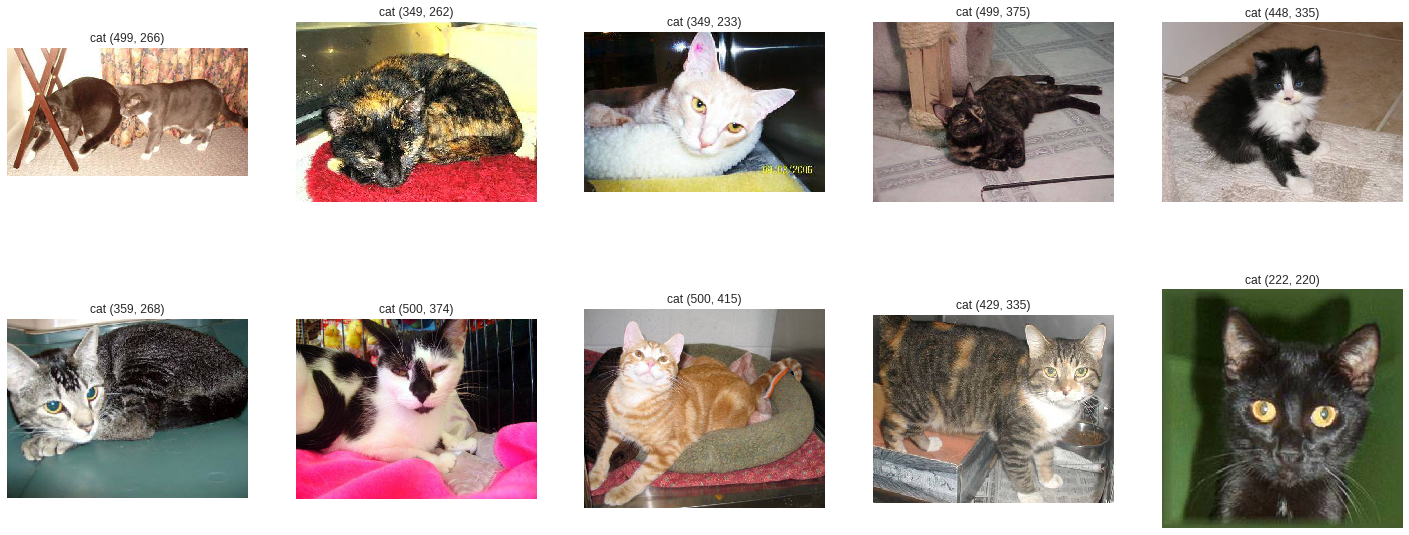

In [0]:
train_x = os.listdir(train_cats_dir)
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 10))

for idx in np.arange(10):
    ax = fig.add_subplot(2, 10/2, idx+1, xticks=[], yticks=[])
    preprocess_img(train_x[idx], ax, 'cat', train_cats_dir)
    # print out the correct label for each image

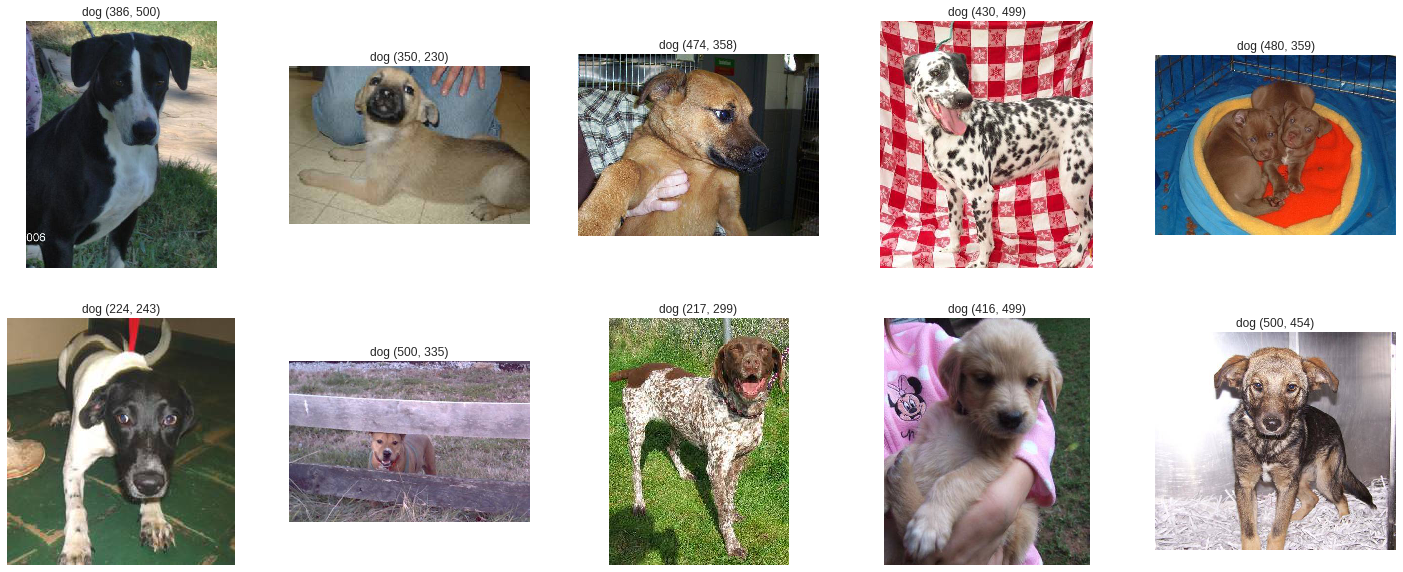

In [0]:
train_x = os.listdir(train_dogs_dir)
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 10))

for idx in np.arange(10):
    ax = fig.add_subplot(2, 10/2, idx+1, xticks=[], yticks=[])
    preprocess_img(train_x[idx], ax, 'dog', train_dogs_dir)
    # print out the correct label for each image


## PyTorch

In [0]:
# load all the required libraries

import time
import copy
import random
import torch                                          # import keras with tensorflow as backend
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.functional as F
from torch.utils.data.sampler import SubsetRandomSampler
import torch.utils.data as data
from torch import optim

np.random.seed(42)

In [0]:
class TestImageFolder(data.Dataset):
    def __init__(self, root, transform=None):
        images = []
        for filename in os.listdir(root):
            if filename.endswith('jpg'):
                images.append('{}'.format(filename))

        self.root = root
        self.imgs = images
        self.transform = transform

    def __getitem__(self, index):
        filename = self.imgs[index]
        img = Image.open(os.path.join(self.root, filename))
        if self.transform is not None:
            img = self.transform(img)
        return img, filename

    def __len__(self):
        return len(self.imgs)

In [0]:
batch_size = 50
num_workers = 0

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/catsvsdogs/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

image_datasets['test'] = TestImageFolder(os.path.join(data_dir, 'test'),
                                          data_transforms['test'])

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
print (dataset_sizes)

# use small subset of train, val and test
num_train = 2000
num_val = 800
num_test = 50
train_indices = np.random.choice(np.arange(dataset_sizes['train']), size=num_train)
val_indices = np.random.choice(np.arange(dataset_sizes['val']), size=num_val)
test_indices = np.random.choice(np.arange(dataset_sizes['test']), size=num_test)

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(image_datasets['train'], batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
val_loader = torch.utils.data.DataLoader(image_datasets['val'], batch_size=batch_size, 
    sampler=val_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(image_datasets['test'], batch_size=batch_size, 
    sampler=test_sampler, num_workers=num_workers)

print('Training samples:', len(train_sampler))
print ('Validation samples:', len(val_sampler))
print('Test samples:', len(test_sampler))

# Create training and validation dataloaders
dataloaders = {'train': train_loader, 
               'val': val_loader}

class_names = image_datasets['train'].classes
print ('Classes:', class_names)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

{'train': 20000, 'val': 5000, 'test': 12500}
Training samples: 2000
Validation samples: 800
Test samples: 50
Classes: ['cats', 'dogs']


In [0]:
print (image_datasets)

{'train': Dataset ImageFolder
    Number of datapoints: 20000
    Root Location: data/catsvsdogs/train
    Transforms (if any): Compose(
                             RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
                             RandomHorizontalFlip(p=0.5)
                             ToTensor()
                             Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                         )
    Target Transforms (if any): None, 'val': Dataset ImageFolder
    Number of datapoints: 5000
    Root Location: data/catsvsdogs/val
    Transforms (if any): Compose(
                             Resize(size=256, interpolation=PIL.Image.BILINEAR)
                             CenterCrop(size=(224, 224))
                             ToTensor()
                             Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                         )
    Target Transforms (if any): None, '

### ConvNet as feature extractor

In [0]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs):
    since = time.time()

    history = dict()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
         # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
#                 scheduler.step()
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                        loss.backward()
                        optimizer.step()
                        
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                    
                    _, preds = torch.max(outputs, 1)

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / (len(dataloaders[phase])*batch_size)
            epoch_acc = running_corrects.double() / (len(dataloaders[phase])*batch_size)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            
            if phase+'_acc' in history:
                # append the new number to the existing array at this slot
                history[phase+'_acc'].append(epoch_acc)
            else:
                # create a new array in this slot
                history[phase+'_acc'] = [epoch_acc]
            
            if phase+'_loss' in history:
                # append the new number to the existing array at this slot
                history[phase+'_loss'].append(epoch_loss)
            else:
                # create a new array in this slot
                history[phase+'_loss'] = [epoch_loss]            

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

In [0]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)
print (model_conv)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# # Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

#number of epochs
epochs = 10

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.torch/models/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:03<00:00, 12081199.37it/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [0]:
model, history = train_model(model_conv, dataloaders, criterion, optimizer, epochs)

Epoch 0/9
----------
train Loss: 0.4100 Acc: 0.8090
val Loss: 0.1569 Acc: 0.9463
Epoch 1/9
----------
train Loss: 0.2078 Acc: 0.9240
val Loss: 0.1021 Acc: 0.9713
Epoch 2/9
----------
train Loss: 0.1875 Acc: 0.9225
val Loss: 0.0953 Acc: 0.9688
Epoch 3/9
----------
train Loss: 0.1726 Acc: 0.9290
val Loss: 0.0841 Acc: 0.9763
Epoch 4/9
----------
train Loss: 0.1630 Acc: 0.9325
val Loss: 0.0804 Acc: 0.9725
Epoch 5/9
----------
train Loss: 0.1522 Acc: 0.9440
val Loss: 0.0781 Acc: 0.9700
Epoch 6/9
----------
train Loss: 0.1652 Acc: 0.9325
val Loss: 0.0731 Acc: 0.9738
Epoch 7/9
----------
train Loss: 0.1656 Acc: 0.9285
val Loss: 0.0752 Acc: 0.9738
Epoch 8/9
----------
train Loss: 0.1459 Acc: 0.9440
val Loss: 0.0719 Acc: 0.9750
Epoch 9/9
----------
train Loss: 0.1558 Acc: 0.9335
val Loss: 0.0767 Acc: 0.9738
Training complete in 5m 58s
Best val Acc: 0.976250


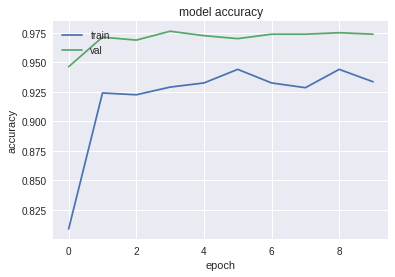

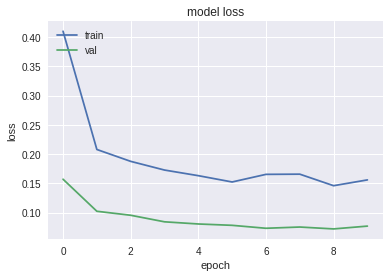

In [0]:
# summarize history for accuracy
plt.plot(history['train_acc'])
plt.plot(history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history['train_loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

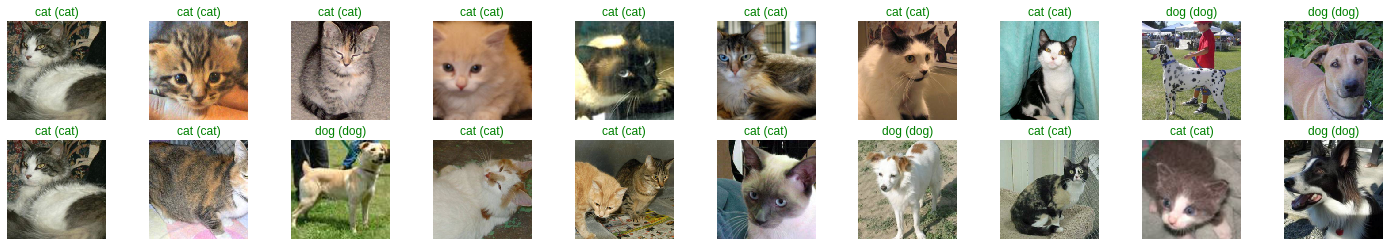

In [0]:
# obtain one batch of val images
dataiter = iter(dataloaders['val'])
images, labels = dataiter.next()

# get sample outputs
output = model(images.to(device))
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.numpy()
labels = labels.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])   
    ax.imshow((np.clip(np.transpose(images[idx], (1, 2, 0))* std + mean, 0, 1)))
    ax.set_title("{} ({})".format(str('cat' if preds[idx]==0 else 'dog'), str('cat' if labels[idx]==0 else 'dog')),
                 color=("green" if preds[idx]==labels[idx] else "red"))

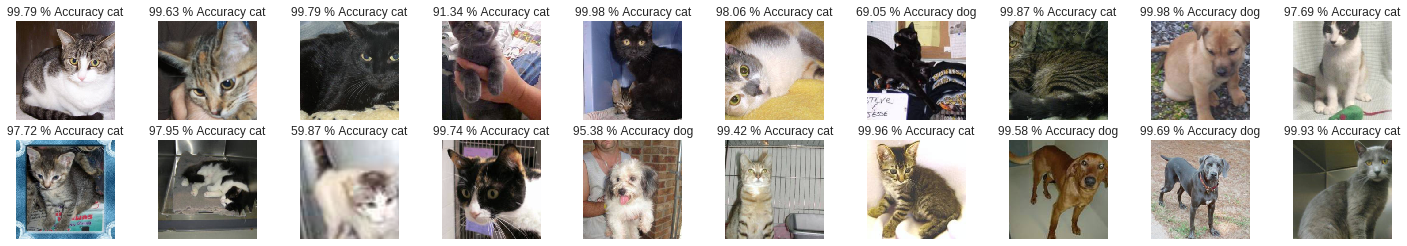

In [0]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, test_filenames = dataiter.next()

# get sample outputs
output = model(images.to(device))
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.numpy()
sm = torch.nn.Softmax(dim=1)
output = sm(output)

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    ax.imshow((np.clip(np.transpose(images[idx], (1, 2, 0))* std + mean, 0, 1)))
    ax.set_title("{:.2f} % Accuracy {}".format(float(output[idx][preds[idx]]*100), str('cat' if preds[idx]==0 else 'dog')))

### Fine tuning

In [0]:
# freeze first 7 blocks of resnet18 model
ct = 0
for i, child in enumerate(model_conv.children()):
  print (i, child)
  ct += 1
  if ct < 7:
      for param in child.parameters():
          param.requires_grad = False

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_conv.fc.parameters(), lr=0.0001, momentum=0.9)

# # Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

0 Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
1 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2 ReLU(inplace)
3 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
4 Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
 

In [0]:
print (model_conv)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [0]:
model, history = train_model(model_conv, dataloaders, criterion, optimizer, epochs)

Epoch 0/9
----------
train Loss: 0.1748 Acc: 0.9305
val Loss: 0.0866 Acc: 0.9688
Epoch 1/9
----------
train Loss: 0.1636 Acc: 0.9280
val Loss: 0.0757 Acc: 0.9750
Epoch 2/9
----------
train Loss: 0.1630 Acc: 0.9305
val Loss: 0.0744 Acc: 0.9750
Epoch 3/9
----------
train Loss: 0.1595 Acc: 0.9375
val Loss: 0.0716 Acc: 0.9750
Epoch 4/9
----------
train Loss: 0.1429 Acc: 0.9390
val Loss: 0.0706 Acc: 0.9763
Epoch 5/9
----------
train Loss: 0.1465 Acc: 0.9340
val Loss: 0.0694 Acc: 0.9775
Epoch 6/9
----------
train Loss: 0.1379 Acc: 0.9490
val Loss: 0.0703 Acc: 0.9725
Epoch 7/9
----------
train Loss: 0.1389 Acc: 0.9405
val Loss: 0.0685 Acc: 0.9725
Epoch 8/9
----------
train Loss: 0.1402 Acc: 0.9410
val Loss: 0.0704 Acc: 0.9775
Epoch 9/9
----------
train Loss: 0.1499 Acc: 0.9405
val Loss: 0.0682 Acc: 0.9725
Training complete in 5m 59s
Best val Acc: 0.977500


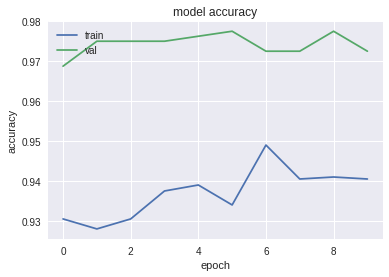

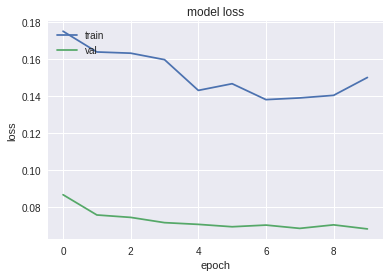

In [0]:
# summarize history for accuracy
plt.plot(history['train_acc'])
plt.plot(history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history['train_loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

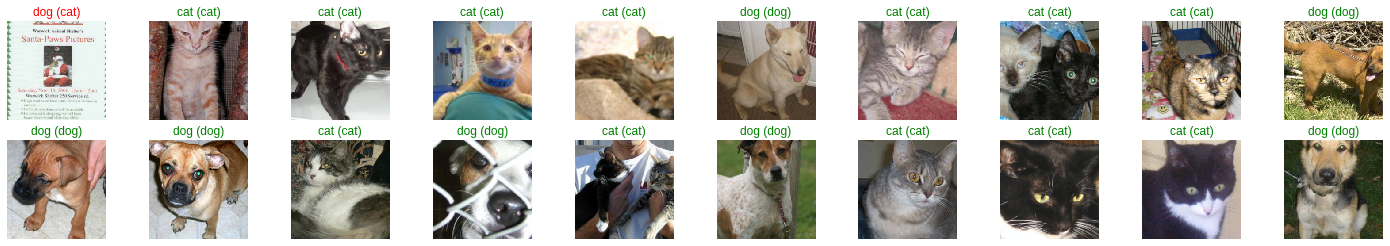

In [0]:
# obtain one batch of val images
dataiter = iter(dataloaders['val'])
images, labels = dataiter.next()

# get sample outputs
output = model(images.to(device))
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.numpy()
labels = labels.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])   
    ax.imshow((np.clip(np.transpose(images[idx], (1, 2, 0))* std + mean, 0, 1)))
    ax.set_title("{} ({})".format(str('cat' if preds[idx]==0 else 'dog'), str('cat' if labels[idx]==0 else 'dog')),
                 color=("green" if preds[idx]==labels[idx] else "red"))

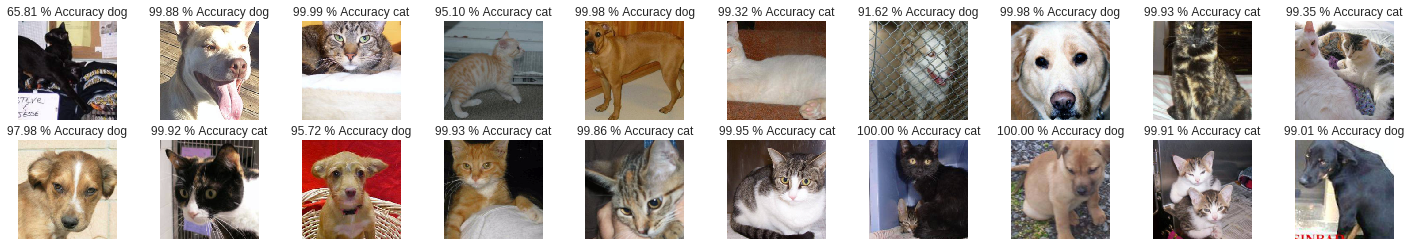

In [0]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, test_filenames = dataiter.next()

# get sample outputs
output = model(images.to(device))
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.numpy()
sm = torch.nn.Softmax(dim=1)
output = sm(output)

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    ax.imshow((np.clip(np.transpose(images[idx], (1, 2, 0))* std + mean, 0, 1)))
    ax.set_title("{:.2f} % Accuracy {}".format(float(output[idx][preds[idx]]*100), str('cat' if preds[idx]==0 else 'dog')))

In [0]:
# save the model
PATH = 'data/'
torch.save(model.state_dict(), PATH)